**Rio de Janeiro, 29 de Junho de 2016**

Grupo: **Carlos Mattoso** _[ **1210553** ]_ e **Gabriel Siqueira** _[ **1210689** ]_

Disciplina: **INF1335 - Introdução a Data Science com R e Python**

# A5 - Rede de Citações

## _Setup_ Básico

In [33]:
options(repr.plot.width = 10)
options(repr.plot.height = 5)

load.lib <- function(lib.name, rep="https://cloud.r-project.org/") {
    if (!require(lib.name, character.only=T))
        install.packages(lib.name, repos=rep)
    library(lib.name, character.only=T)
}
load.lib("data.table")
load.lib("knitr")
load.lib("ggplot2")
load.lib("plyr")

printf <- function(...) invisible(cat(paste(sprintf(...), "\n", sep=""))) # source: http://stackoverflow.com/a/13023329
# Usage example: print("%s %d", Number, 5)

dir.create("data", showWarnings = FALSE)

# Baixa os dados da pasta HCI do github para uma pasta local `data`
github.base.url = "https://raw.githubusercontent.com/calmattoso/INF1335/master/A5/ihc/" 
file.names = c("artigo", "autor", "instituicao", "keyword", "pessoa", "referencia")
for (file.name in file.names) {
    file.name.extension = paste(file.name, ".csv", sep="")
    file.path = paste("data/", file.name.extension, sep="")
    if (!file.exists(file.path))    
        download.file(paste(github.base.url, file.name.extension, sep=""), destfile=file.path, method="curl")
}
 
# Show user message indicating that different results might be observed if R version is less than 3.2.2
r.version = R.Version()
if (r.version$major < "3") {
    print("This notebook was develop under R major version 3. If your machine runs a version below 3, abnormal behavior should be expected.")
} else if (paste(r.version$major, r.version$minor, sep="") < "3.2.2") {
    print("This notebook was developed under R version 3.2.2.  If your machine runs a version below this, small differences could occur.")
}

## Leitura Inicial dos Dados

In [34]:
data.map = list()
for (file.name in file.names) {
    file.name.extension = paste(file.name, ".csv", sep="")
    file.path = paste("data/", file.name.extension, sep="")
    
    # Read strings as strings due to the nature of the files. This can be fixed on a case by case basis later
    if (file.exists(file.path))    
        data.map[[file.name]] = read.csv(file.path, fileEncoding="UTF-8", stringsAsFactor=F)
}
summary(data.map)

            Length Class      Mode
artigo      8      data.frame list
autor       7      data.frame list
instituicao 6      data.frame list
keyword     3      data.frame list
pessoa      3      data.frame list
referencia  9      data.frame list

## Examinação dos Dados

### Funções Auxiliares

In [35]:
# Exibe algumas estatísticas de atributos do tipo "character"
explore.text.attr <- function(attr.data, attr.name) {
    if (typeof(attr.data) == "character") {
        printf("Análise Exploratória de `%s`", attr.name)
        printf("  Número de valores distintos e total: %d/%d", 
               length(unique(attr.data)), length(attr.data))

        printf("  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): %d (%%%.2f)", 
               sum(attr.data != ""), sum(attr.data != "")/length(attr.data)*100.0)
        
        random.attr.sample = sample(attr.data[attr.data != ""], 5, replace=T)
        printf("  Amostra de instâncias de `%s`:", attr.name)
        printf("    %s", random.attr.sample)
        printf("")
    }
}

# Executa a exploração básica de uma base de dados
explore.dataset <- function(dataset.name) {
    dataset = data.map[[dataset.name]]

    # Exploração dos atributos de tipo "char" da base de dados
    for (attr.name in names(dataset)) {
        explore.text.attr(dataset[[attr.name]], attr.name)
    }
    
    dataset
}

### _artigo.csv_

Utilizemos as funções `str` e `summary` para entender a forma dos dados lidos e se seus tipos são apropriados. Além disso, exibem-se algumas estatísticas sobre atributos textuais, a fim de determinar o melhor tipo para representá-los e detecção de valores faltantes (_missing values_).

In [36]:
dataset.name = "artigo"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
artigo = explore.dataset(dataset.name)

'data.frame':	340 obs. of  8 variables:
 $ id_artigo    : int  4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 ...
 $ ano          : int  1998 1998 1998 1998 1998 1998 1998 1998 1998 1998 ...
 $ titulo       : chr  "Uma Abordagem Semiótica à Análise de Interfaces: um estudo de caso" "Knowledge and Communication Perspectives in Extensible Applications" "Uma Abordagem Ergonômica para o Desenvolvimento de Sistemas Interativos" "Estudo de Interação para um Sistema de Ensino à Distância Baseado em Interfaces de Realidade Virtual" ...
 $ idioma       : chr  "PT-BR" "EN" "PT-BR" "PT-BR" ...
 $ tema         : chr  "" "" "" "" ...
 $ acm_chave    : chr  "" "" "" "" ...
 $ acm_categoria: chr  "" "" "" "" ...
 $ acm_termos   : chr  "" "" "" "" ...


   id_artigo         ano          titulo             idioma         
 Min.   :4506   Min.   :1998   Length:340         Length:340        
 1st Qu.:4591   1st Qu.:2002   Class :character   Class :character  
 Median :4676   Median :2010   Mode  :character   Mode  :character  
 Mean   :4677   Mean   :2008                                        
 3rd Qu.:4760   3rd Qu.:2013                                        
 Max.   :4854   Max.   :2015                                        
     tema            acm_chave         acm_categoria       acm_termos       
 Length:340         Length:340         Length:340         Length:340        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                       

,id_artigo,ano,titulo,idioma,tema,acm_chave,acm_categoria,acm_termos
1,4506,1998,Uma Abordagem Semiótica à Análise de Interfaces: um estudo de caso,PT-BR,,,,
2,4507,1998,Knowledge and Communication Perspectives in Extensible Applications,EN,,,,
3,4508,1998,Uma Abordagem Ergonômica para o Desenvolvimento de Sistemas Interativos,PT-BR,,,,
4,4509,1998,Estudo de Interação para um Sistema de Ensino à Distância Baseado em Interfaces de Realidade Virtual,PT-BR,,,,
5,4510,1998,APIS: Método para Desenvolvimento de Interfaces Homem-Computador em Sistemas de Segurança Visando a Confiabilidade Humana,PT-BR,,,,
6,4511,1998,"Interação, Interfaces e Instrumentos em Música Eletroacústica",PT-BR,,,,


,id_artigo,ano,titulo,idioma,tema,acm_chave,acm_categoria,acm_termos
335,4849,2015,O Pensamento Computacional Através de Jogos Infantis,PT-BR,education and hci,H.5.2. User Interfaces.,,
336,4850,2015,Investigating Treemap Visualization in Inverted Scale,EN,information visualization,H.5.2. User Interfaces: Evaluation/Methodology,,
337,4851,2015,Visualization Mechanisms for Crowdsourcing Information in Emergency Coordination,EN,information visualization,H.4.2 Information system applications: Types of Systems— decision support,,
338,4852,2015,Eye Jam: A Gaze-Controlled Musical Interface,EN,interaction with new devices,"H.5.2 User Interfaces: Interaction styles, theory and methods, I.3.6 Methodology and Techniques: Int",,
339,4853,2015,Identifying Cognitive Authority in Social Networks: a conceptual framework,EN,social interaction,H.5 Information Interfaces and Presentation: General,,
340,4854,2015,Interaction Design Process for Healthcare Professionals: formalizing user's contexts observations,EN,design and evaluation,H.5.2. User interface,,


Análise Exploratória de `titulo`
  Número de valores distintos e total: 340/340
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 340 (%100.00)
  Amostra de instâncias de `titulo`:
    Estudo Comparativo entre Técnicas de Inspeção de Usabilidade sobre Diagramas de Atividades
     ActiveIris: Uma solução para comunicação alternativa e autonomia de pessoas com deficiência motora severa
     Uma Abordagem Semiótica à Análise de Interfaces: um estudo de caso
     Caracterização de Estratégias de Gamificação em Aplicativos Móveis Educacionais: Um Estudo de Caso do Aplicativo Duolingo
     The Role of Designer-Generated Scenarios in Developing Web Applications: A Case Study

Análise Exploratória de `idioma`
  Número de valores distintos e total: 5/340
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 340 (%100.00)
  Amostra de instâncias de `idioma`:
    PT-BR
     PT-BR
     PT-BR
     PT-PT
     PT-BR

Análise Exploratória de `tema`
  Número de valores d

Observa-se que os atributos _acm_ tem bastante dados faltantes, pecando a base então em capturar sua informação. Contudo, seu tipo ser _character_ faz sentido. Por outro lado, o atributo _idioma_ define um conjunto restrito de línguas, sendo então razoável atualizar seu tipo para _factor_. Os demais atributos não apresentam valores faltantes, o que é sempre agradável de se ver.

In [37]:
artigo$idioma = as.factor(artigo$idioma)
summary(artigo$idioma)

EN    ES  P-BR PT-BR PT-PT 
  108     2     1   228     1

Aqui já se observa uma oportunidade de limpar nossos dados. Existem duas classificações para o idioma Português do Brasil, `P-BR` e `PT-BR`, o que deve ser um erro. Há ainda uma instância discriminada a Português de Portugual (`PT-PT`). Optamos por fundir estes três tipos simplesmente como `PT`, seguindo a forma das demais classificações de idiomas da base, `EN` para inglês e `ES` para espanhol.

In [38]:
artigo$idioma = as.character(artigo$idioma)
artigo$idioma[artigo$idioma == "P-BR" | artigo$idioma == "PT-PT" | artigo$idioma == "PT-BR"] = "PT"
artigo$idioma = as.factor(artigo$idioma)
summary(artigo$idioma)

EN  ES  PT 
108   2 230

Apresenta-se abaixo o `summary` e `str` do resultado da limpeza da base _artigo.csv_:

In [39]:
data.map[["artigo"]] = artigo
summary(data.map[["artigo"]])
str(data.map[["artigo"]])

   id_artigo         ano          titulo          idioma       tema          
 Min.   :4506   Min.   :1998   Length:340         EN:108   Length:340        
 1st Qu.:4591   1st Qu.:2002   Class :character   ES:  2   Class :character  
 Median :4676   Median :2010   Mode  :character   PT:230   Mode  :character  
 Mean   :4677   Mean   :2008                                                 
 3rd Qu.:4760   3rd Qu.:2013                                                 
 Max.   :4854   Max.   :2015                                                 
  acm_chave         acm_categoria       acm_termos       
 Length:340         Length:340         Length:340        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         

'data.frame':	340 obs. of  8 variables:
 $ id_artigo    : int  4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 ...
 $ ano          : int  1998 1998 1998 1998 1998 1998 1998 1998 1998 1998 ...
 $ titulo       : chr  "Uma Abordagem Semiótica à Análise de Interfaces: um estudo de caso" "Knowledge and Communication Perspectives in Extensible Applications" "Uma Abordagem Ergonômica para o Desenvolvimento de Sistemas Interativos" "Estudo de Interação para um Sistema de Ensino à Distância Baseado em Interfaces de Realidade Virtual" ...
 $ idioma       : Factor w/ 3 levels "EN","ES","PT": 3 1 3 3 3 3 3 3 3 3 ...
 $ tema         : chr  "" "" "" "" ...
 $ acm_chave    : chr  "" "" "" "" ...
 $ acm_categoria: chr  "" "" "" "" ...
 $ acm_termos   : chr  "" "" "" "" ...


### _autor.csv_ 


In [40]:
dataset.name = "autor"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
autor = explore.dataset(dataset.name)

'data.frame':	1054 obs. of  7 variables:
 $ id_autor             : int  2 1 1 3 4 5 6 7 7 8 ...
 $ id_artigo            : int  4607 4533 4556 4831 4602 4822 4604 4556 4533 4654 ...
 $ id_pessoa            : int  1 1 1 2 3 4 5 6 6 7 ...
 $ id_instituicao       : int  74 112 111 14 66 231 87 83 83 130 ...
 $ instituicao_principal: chr  "S" "S" "S" "S" ...
 $ nome                 : chr  "Adéle Malta Pontes" "Adéle Malta Pontes" "Adéle Malta Pontes" "Adriana Euflasino" ...
 $ email                : chr  "adele@inf.puc-rio.br" "Deli@atlas.ucpel.tche.br" "Deli@atlas.ucpel.tche.br" "adrianaeuflasino@cpfl.com.br" ...


    id_autor       id_artigo      id_pessoa     id_instituicao 
 Min.   :  1.0   Min.   :4506   Min.   :  1.0   Min.   :  1.0  
 1st Qu.:177.0   1st Qu.:4595   1st Qu.:157.0   1st Qu.: 86.0  
 Median :358.5   Median :4682   Median :320.5   Median :167.0  
 Mean   :345.5   Mean   :4681   Mean   :307.0   Mean   :158.5  
 3rd Qu.:505.8   3rd Qu.:4767   3rd Qu.:451.8   3rd Qu.:219.0  
 Max.   :659.0   Max.   :4854   Max.   :579.0   Max.   :292.0  
 instituicao_principal     nome              email          
 Length:1054           Length:1054        Length:1054       
 Class :character      Class :character   Class :character  
 Mode  :character      Mode  :character   Mode  :character  
                                                            
                                                            
                                                            

,id_autor,id_artigo,id_pessoa,id_instituicao,instituicao_principal,nome,email
1,2,4607,1,74,S,Adéle Malta Pontes,adele@inf.puc-rio.br
2,1,4533,1,112,S,Adéle Malta Pontes,Deli@atlas.ucpel.tche.br
3,1,4556,1,111,S,Adéle Malta Pontes,Deli@atlas.ucpel.tche.br
4,3,4831,2,14,S,Adriana Euflasino,adrianaeuflasino@cpfl.com.br
5,4,4602,3,66,S,Adriana Holtz Betiol,abetiol@netpar.com.br
6,5,4822,4,231,S,Adriana Lopes,adriana@icomp.ufam.edu.br


,id_autor,id_artigo,id_pessoa,id_instituicao,instituicao_principal,nome,email
1049,654,4697,574,2,S,Wander Antunes Gaspar Valente,wandergaspar@gmail.com
1050,655,4545,575,213,S,Wellington B. do Nascimento Jr.,wess@eps.ufsc.br
1051,656,4700,576,39,S,William J. Giraldo,aaaa@aaaa.aaa.aaa
1052,657,4778,577,232,S,Williamson Silva,williamson.silva@icomp.ufam.edu.br
1053,658,4787,578,57,S,Yngve Sundblad,y@kth.se
1054,659,4633,579,101,S,Yulia Ostróvskaya,yuliaa.ostrovskaya@udlap.mx


Análise Exploratória de `instituicao_principal`
  Número de valores distintos e total: 2/1054
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 1054 (%100.00)
  Amostra de instâncias de `instituicao_principal`:
    S
     S
     S
     S
     S

Análise Exploratória de `nome`
  Número de valores distintos e total: 579/1054
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 1054 (%100.00)
  Amostra de instâncias de `nome`:
    Raquel Oliveira Prates
     Juliana Jansen Ferreira
     Silvia Schiaffino
     Luciana Correia Lima de Faria Borges
     Taciana Pontual Falcão

Análise Exploratória de `email`
  Número de valores distintos e total: 622/1054
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 1048 (%99.43)
  Amostra de instâncias de `email`:
    aaaa@aaaa.aaa.aaa
     rpereira@ic.unicamp.br
     heloisa@ic.unicamp.br
     ceciliak@inf.puc-rio.br
     elizabet@unifor.br



Aqui não se observa a ausência de valores. O único ajuste válido é alterar o tipo da variável `instituicao_principal` para `factor`, visto que ela indica `Sim` ou `Não` para se a instituição referenciada é principal ou não.

In [41]:
autor$instituicao_principal = as.factor(autor$instituicao_principal)
data.map[[dataset.name]] = autor
summary(data.map[[dataset.name]])
str(data.map[[dataset.name]])

    id_autor       id_artigo      id_pessoa     id_instituicao 
 Min.   :  1.0   Min.   :4506   Min.   :  1.0   Min.   :  1.0  
 1st Qu.:177.0   1st Qu.:4595   1st Qu.:157.0   1st Qu.: 86.0  
 Median :358.5   Median :4682   Median :320.5   Median :167.0  
 Mean   :345.5   Mean   :4681   Mean   :307.0   Mean   :158.5  
 3rd Qu.:505.8   3rd Qu.:4767   3rd Qu.:451.8   3rd Qu.:219.0  
 Max.   :659.0   Max.   :4854   Max.   :579.0   Max.   :292.0  
 instituicao_principal     nome              email          
 N:  46                Length:1054        Length:1054       
 S:1008                Class :character   Class :character  
                       Mode  :character   Mode  :character  
                                                            
                                                            
                                                            

'data.frame':	1054 obs. of  7 variables:
 $ id_autor             : int  2 1 1 3 4 5 6 7 7 8 ...
 $ id_artigo            : int  4607 4533 4556 4831 4602 4822 4604 4556 4533 4654 ...
 $ id_pessoa            : int  1 1 1 2 3 4 5 6 6 7 ...
 $ id_instituicao       : int  74 112 111 14 66 231 87 83 83 130 ...
 $ instituicao_principal: Factor w/ 2 levels "N","S": 2 2 2 2 2 2 2 2 2 2 ...
 $ nome                 : chr  "Adéle Malta Pontes" "Adéle Malta Pontes" "Adéle Malta Pontes" "Adriana Euflasino" ...
 $ email                : chr  "adele@inf.puc-rio.br" "Deli@atlas.ucpel.tche.br" "Deli@atlas.ucpel.tche.br" "adrianaeuflasino@cpfl.com.br" ...


### _instituicao.csv_ 

In [42]:
dataset.name = "instituicao"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
instituicao = explore.dataset(dataset.name)

'data.frame':	292 obs. of  6 variables:
 $ id_instituicao: int  74 112 111 14 66 231 87 83 130 121 ...
 $ instituicao   : chr  "Pontifícia Universidade Católica do Rio de Janeiro" "Universidade Católica de Pelotas" "Universidade Católica de Pelotas" "Companhia Paulista de Força e Luz Paulista" ...
 $ sigla         : chr  "PUC-Rio" "UCPEL" "UCPel" "CPFL" ...
 $ departamento  : chr  "Depto de Informática" "" "" "" ...
 $ estado        : chr  "RJ" "RS" "RS" "SP" ...
 $ pais          : chr  "Brasil" "Brasil" "Brasil" "Brasil" ...


 id_instituicao   instituicao           sigla           departamento      
 Min.   :  1.00   Length:292         Length:292         Length:292        
 1st Qu.: 73.75   Class :character   Class :character   Class :character  
 Median :146.50   Mode  :character   Mode  :character   Mode  :character  
 Mean   :146.50                                                           
 3rd Qu.:219.25                                                           
 Max.   :292.00                                                           
    estado              pais          
 Length:292         Length:292        
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

,id_instituicao,instituicao,sigla,departamento,estado,pais
1,74,Pontifícia Universidade Católica do Rio de Janeiro,PUC-Rio,Depto de Informática,RJ,Brasil
2,112,Universidade Católica de Pelotas,UCPEL,,RS,Brasil
3,111,Universidade Católica de Pelotas,UCPel,,RS,Brasil
4,14,Companhia Paulista de Força e Luz Paulista,CPFL,,SP,Brasil
5,66,Pontifícia Universidade Católica do Paraná,PUCPR,,PR,Brasil
6,231,Universidade Federal do Amazonas,UFAM,Grupo de Pesquisa sobre Usabilidade e Engenharia de Software,AM,Brasil


,id_instituicao,instituicao,sigla,departamento,estado,pais
287,94,Tecnologico Autónomo de México,ITAM,Computer Science Department Instituto,,México
288,191,Universidade Federal de Mato Grosso,UFMT,Instituto de Linguagens,MT,Brasil
289,51,Instituto Federal de Mato Grosso,IFMT,Área de Linguagens,MT,Brasil
290,77,Pontifícia Universidade Católica do Rio de Janeiro,PUC-Rio,Depto. de Letras,RJ,Brasil
291,206,Universidade Federal de Santa Catarina,UFSC,CTC,SC,Brasil
292,213,Universidade Federal de Santa Catarina,UFSC,Programa de Pós Graduação em Ciência da Computação,SC,Brasil


Análise Exploratória de `instituicao`
  Número de valores distintos e total: 137/292
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 292 (%100.00)
  Amostra de instâncias de `instituicao`:
    Universidade Estadual de Maringá
     Pontifícia Universidade Católica do Rio de Janeiro
     KTH Royal Institute of Technology
     Universidade Católica de Pelotas
     Faculdade Pedro Leopoldo

Análise Exploratória de `sigla`
  Número de valores distintos e total: 130/292
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 269 (%92.12)
  Amostra de instâncias de `sigla`:
    PUCRS
     UFMA
     FATEC Itu
     UDESC
     UERJ

Análise Exploratória de `departamento`
  Número de valores distintos e total: 126/292
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 159 (%54.45)
  Amostra de instâncias de `departamento`:
    COPPEAD
     Departamento de Ciência da Computação
     Communication and Computing Research Centre Sheffield Hallam Univer

Esta base de dados tem algumas informações sobre as diferentes instituições de ensino superior que participaram dos eventos de IHC. Não há nada muito crítico aqui, havendo no geral poucos dados faltantes, exceto no caso de departamento, que não foi reportado para 50% dos casos. Além disso, os tipos são condizentes com o significado dos atributos. Por fim, uma observação interessante pode ser feita para o atributo `estado`:

In [43]:
print(unique(instituicao$estado))
print(unique(instituicao$pais))

 [1] "RJ" "RS" "SP" "PR" "AM" "CE" "PE" "MG" "RN" "MT" "GO" ""   "PB" "BA" "1" 
[16] "SC" "MA" "ES" "DF" "AC" "PA" "SE" "MS"
 [1] "Brasil"     ""           "México"     "Argentina"  "Suécia"    
 [6] "Colômbia"   "Inglaterra" "França"     "Chike"      "Chile"     
[11] "Bélgica"    "Canadá"     "Alemanha"   "Portugal"   "Itália"    
[16] "Espanha"   


Apenas estados brasileiros parecem ser reportados, embora haja outros países. Além disso, por algum motivo o valor `"1"` surge na lista de estados. Substituem-se as _strings_ vazias acima e esse valor de "1" por `NA`. Note ainda que há referência a um país _Chike_, que [não existe](http://www.un.org/en/member-states/index.html#gotoC); isto é provavelmente um _typo_, então modificamos ocorrências de tal valor para _Chile_.

In [44]:
# Definição de _string_ vazia como `NA`
instituicao$departamento[instituicao$departamento == ""] = NA
instituicao$pais[instituicao$pais == ""] = NA
instituicao$estado[instituicao$estado == "" | instituicao$estado == "1"] = NA

# Correção de _Chike_ para _Chile_
instituicao$pais[instituicao$pais == "Chike"] = "Chile"

# Atualização do banco de dados central
data.map[[dataset.name]] = instituicao
summary(data.map[[dataset.name]])
str(data.map[[dataset.name]])

 id_instituicao   instituicao           sigla           departamento      
 Min.   :  1.00   Length:292         Length:292         Length:292        
 1st Qu.: 73.75   Class :character   Class :character   Class :character  
 Median :146.50   Mode  :character   Mode  :character   Mode  :character  
 Mean   :146.50                                                           
 3rd Qu.:219.25                                                           
 Max.   :292.00                                                           
    estado              pais          
 Length:292         Length:292        
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

'data.frame':	292 obs. of  6 variables:
 $ id_instituicao: int  74 112 111 14 66 231 87 83 130 121 ...
 $ instituicao   : chr  "Pontifícia Universidade Católica do Rio de Janeiro" "Universidade Católica de Pelotas" "Universidade Católica de Pelotas" "Companhia Paulista de Força e Luz Paulista" ...
 $ sigla         : chr  "PUC-Rio" "UCPEL" "UCPel" "CPFL" ...
 $ departamento  : chr  "Depto de Informática" NA NA NA ...
 $ estado        : chr  "RJ" "RS" "RS" "SP" ...
 $ pais          : chr  "Brasil" "Brasil" "Brasil" "Brasil" ...


### _keyword.csv_ 

In [45]:
dataset.name = "keyword"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
keyword = explore.dataset(dataset.name)

'data.frame':	1176 obs. of  3 variables:
 $ id_artigo: int  4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 ...
 $ keyword  : chr  "interface" "end-user programming" "ergonomia" "interação homem-máquina" ...
 $ posicao  : int  1 1 1 1 1 1 1 1 1 1 ...


   id_artigo      keyword             posicao     
 Min.   :4506   Length:1176        Min.   :1.000  
 1st Qu.:4630   Class :character   1st Qu.:1.750  
 Median :4707   Mode  :character   Median :3.000  
 Mean   :4696                      Mean   :2.676  
 3rd Qu.:4777                      3rd Qu.:4.000  
 Max.   :4854                      Max.   :7.000  

,id_artigo,keyword,posicao
1,4506,interface,1
2,4507,end-user programming,1
3,4508,ergonomia,1
4,4509,interação homem-máquina,1
5,4510,confiabilidade humana,1
6,4511,interação musical - interfaces musicais - ins,1


,id_artigo,keyword,posicao
1171,4639,semiotic engineering,7
1172,4715,abstraction,7
1173,4764,comunicabilidade,7
1174,4770,semiotic engineering,7
1175,4782,mobile application,7
1176,4841,braindraw,7


Análise Exploratória de `keyword`
  Número de valores distintos e total: 866/1176
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 1176 (%100.00)
  Amostra de instâncias de `keyword`:
    redes sociais online
     human computer interaction
     design
     non-visual games
     design centrado no usuário



Esta tabela faz um mero mapeamento entre as palavras-chave e os artigos definidos em _artigo.csv_ no qual são usadas, através de uma chave estrangeiras para a _id_ dos artigos. Não há dados faltantes e os tipos condizem com o significado dos atributos, então seguimos adiante.

### _pessoa.csv_ 

In [46]:
dataset.name = "pessoa"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
pessoa = explore.dataset(dataset.name)

'data.frame':	579 obs. of  3 variables:
 $ id_pessoa: int  1 2 3 4 5 6 7 8 9 10 ...
 $ nome     : chr  "Adéle Malta Pontes" "Adriana Euflasino" "Adriana Holtz Betiol" "Adriana Lopes" ...
 $ nome_ref : chr  "Pontes, A. M." "Euflasino, A." "Betiol, A. H." "Lopes, A." ...


   id_pessoa         nome             nome_ref        
 Min.   :  1.0   Length:579         Length:579        
 1st Qu.:145.5   Class :character   Class :character  
 Median :290.0   Mode  :character   Mode  :character  
 Mean   :290.0                                        
 3rd Qu.:434.5                                        
 Max.   :579.0                                        

,id_pessoa,nome,nome_ref
1,1,Adéle Malta Pontes,"Pontes, A. M."
2,2,Adriana Euflasino,"Euflasino, A."
3,3,Adriana Holtz Betiol,"Betiol, A. H."
4,4,Adriana Lopes,"Lopes, A."
5,5,Adriano Gonella,"Gonella, A."
6,6,Afonso Inácio Orth,"Orth, A. I."


,id_pessoa,nome,nome_ref
574,574,Wander Antunes Gaspar Valente,"Valente, W. A. G."
575,575,Wellington B. do Nascimento Jr.,"Jr., W. B. d. N."
576,576,William J. Giraldo,"Giraldo, W. J."
577,577,Williamson Silva,"Silva, W."
578,578,Yngve Sundblad,"Sundblad, Y."
579,579,Yulia Ostróvskaya,"Ostróvskaya, Y."


Análise Exploratória de `nome`
  Número de valores distintos e total: 579/579
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 579 (%100.00)
  Amostra de instâncias de `nome`:
    Roberto C. M. Borges
     Matheus Araújo
     Luciana da Silveira Espindola
     Cristian A. Rusu
     Simone Xavier

Análise Exploratória de `nome_ref`
  Número de valores distintos e total: 574/579
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 579 (%100.00)
  Amostra de instâncias de `nome_ref`:
    Miletto, E. M.
     Silva, B. S. G.
     Ribeiro, A. P.
     Ribeiro, M. X.
     Assaf, R.



Esta tabela faz um mero mapeamento entre o identificador, o nome e a referência dos autores citados ou que publicaram os artigos. Não há dados faltantes e os tipos condizem com o significado dos atributos, então seguimos adiante.

### _referencia.csv_

In [47]:
dataset.name = "referencia"
str(data.map[[dataset.name]])
summary(data.map[[dataset.name]])
head(data.map[[dataset.name]])
tail(data.map[[dataset.name]])
referencia = explore.dataset(dataset.name)

'data.frame':	7350 obs. of  9 variables:
 $ idpaper       : int  4506 4506 4506 4506 4506 4506 4506 4506 4506 4506 ...
 $ referencia    : chr  "Andersen, P. B. (1997). A Theory of Computer Semiotics. Updated ed. of 1990.NewYork: Cambridge UniversityPress." "Card, S. K., Moran, T. P., Newell, A. (1983). The Psycology of Human-Computer Interaction. Hillsdale: Lawrence Erlbaum Associat"| __truncated__ "Familant, M.E., Detweiler, M.C. (1993). Iconic reference: evolving perspectives and an organizing framework.International Journ"| __truncated__ "Jorna, R.; Van Heusden, B. (1996). Semiotics of user interface. Semiotica. V. 109, n.3/4, p. 237-250." ...
 $ tiporef       : chr  "L" "L" "P" "P" ...
 $ anoref        : int  1997 1983 1993 1996 1990 1988 1986 1986 1983 1986 ...
 $ siglaref      : chr  "Cambridge University" "Erlbaum" "IJMMS" "Semiotica" ...
 $ idiomaref     : chr  "EN" "EN" "EN" "EN" ...
 $ id_referencias: int  1 2 3 4 5 6 7 8 9 10 ...
 $ ni            : chr  "" "" "" "" ...
 $ tr

    idpaper      referencia          tiporef              anoref    
 Min.   :4506   Length:7350        Length:7350        Min.   :1916  
 1st Qu.:4614   Class :character   Class :character   1st Qu.:1998  
 Median :4693   Mode  :character   Mode  :character   Median :2004  
 Mean   :4690                                         Mean   :2002  
 3rd Qu.:4770                                         3rd Qu.:2009  
 Max.   :4854                                         Max.   :2015  
                                                      NA's   :192   
   siglaref          idiomaref         id_referencias      ni           
 Length:7350        Length:7350        Min.   :   1   Length:7350       
 Class :character   Class :character   1st Qu.:1838   Class :character  
 Mode  :character   Mode  :character   Median :3676   Mode  :character  
                                       Mean   :3676                     
                                       3rd Qu.:5513                     
          

,idpaper,referencia,tiporef,anoref,siglaref,idiomaref,id_referencias,ni,trad.sn
1,4506,"Andersen, P. B. (1997). A Theory of Computer Semiotics. Updated ed. of 1990.NewYork: Cambridge UniversityPress.",L,1997,Cambridge University,EN,1,,
2,4506,"Card, S. K., Moran, T. P., Newell, A. (1983). The Psycology of Human-Computer Interaction. Hillsdale: Lawrence Erlbaum Associates.",L,1983,Erlbaum,EN,2,,
3,4506,"Familant, M.E., Detweiler, M.C. (1993). Iconic reference: evolving perspectives and an organizing framework.International Journal of Man-Machine Studies, V. 39, n. 4, p. 705-728.",P,1993,IJMMS,EN,3,,
4,4506,"Jorna, R.; Van Heusden, B. (1996). Semiotics of user interface. Semiotica. V. 109, n.3/4, p. 237-250.",P,1996,Semiotica,EN,4,,
5,4506,"Laurel, B. (1990). The Art of Human-Computer Interaction. Reading, MA: Addison-Wesley.",L,1990,ADDISON WESLEY,EN,5,I,N
6,4506,"Nadin, M. (1988). Interface design: A semiotic paradigm. Semiotica. V. 69, n.3/4, p.269-302.",P,1988,Semiotica,EN,6,,


,idpaper,referencia,tiporef,anoref,siglaref,idiomaref,id_referencias,ni,trad.sn
7345,4854,"Oliveira, J. L. Recommendation System for Promotion of Homophile Networks Based in Cultural Values: observing the impact of homophile on reciprocity relations supported by technology. Master Degree Dissertation. Federal University of São Carlos/Brazil. (2013). 76 p. In Portuguese.",D,2013,Mestrado,EN,7345,,
7346,4854,"Picollo, R. S. G; Baranauskas, M. C. C. Making Sense of the Affordance Conception in the 3rd HCI Paradigm. In: Proceedings of IADIS International Conference WWW/Internet, (IADIS Press). (2010). p. 183-191.",C,2010,IADIS,EN,7346,,
7347,4854,"Preece, J.; Rogers, Y.; Sharp, H. Interaction Design. 1st edition. (2002).",L,2002,Wiley,EN,7347,,
7348,4854,"Rogers, Y.; Sharp, H.; Preece, J. Interaction Design: beyond human-computer interaction. 3rd edition, John Wiley & Sons Ltd. (2011). 585 p.",L,2011,John Wiley & Sons,EN,7348,,
7349,4854,"Saffer, D. Design for Interaction: creating smart application and clever device. 2nd edition. New Riders Press, 2010. 223 p.",L,2010,New Riders Press,EN,7349,,
7350,4854,"Silva M. A. R.; Anacleto, J. C. Adding Semantic Relations among Design Patterns. In: Proceedings of the 15th International Conference on Enterprise Information Systems. Portugal: SCITEPRESS Science and Technology Publications. (2014). v. 1. p. 1-11.",C,2014,ICEIS,EN,7350,,


Análise Exploratória de `referencia`
  Número de valores distintos e total: 7276/7350
  Quantas instâncias tem conteúdo não vazio (não é `string` vazio): 7350 (%100.00)
  Amostra de instâncias de `referencia`:
    (Bercht et al., 1999) BERCHT, M.; MOISSA, H.E.M; VICCARI, R.M. Identificação de fatores motivacionais e afetivos em um ambiente de ensino e aprendizagem. SBIE’99. Novembro 23-25, 1999, Curitiba, PR (Poster).
     von Wright, G.H. 1963. Norm and action: a logical enquiry. International Library of Philosophy and Scientific Method.
     Conallen, J. (2000) ?Building Web Applications with UML?, Addison Wesley, USA.
     Guedes, D.; Meira Jr., W.; Ferreira, F.. Anteater: A Service- Oriented Architecture for High Performance Data Mining. IEEE Internet Computing, Vol 10, No 4, July/August 2006
     W.J. Conover. 1999. Practical nonparametric statistics. Wiley.

Análise Exploratória de `tiporef`
  Número de valores distintos e total: 8/7350
  Quantas instâncias tem conteúdo não vazio

Esta base de dados faz um cruzamento entre os artigos descritos em _artigo.csv_ e as referências por eles feitas, descrevendo em maiores detalhes tais referências.

Há poucos dados faltantes para as principais variáveis, sendo `anoref` o caso mais nítido; são, porém, menos de 200 dados faltantes para mais de 7000 instâncias. Em todo caso, _strings_ vazias são salvas como `NA`, para terem valor semântico correto em `R`. 

Ainda, assim como feito em _artigo.csv_ para o atributo `idioma`, é válido analizar e manipular os atributos `tiporef` e `idiomaref`, por exemplo, alterando seu tipo de _character_ para _factor_, já que tais atributos definem um conjunto discreto e limitado de classes. Ainda é válido registrar os possíveis signficados dos valores distintos de `tiporef`, com base nas informações da base de dados:
- `L`: _Books_
- `R`: _Tech Report_
- `P`: _Journals_
- `C`: _Conference_
- `O`: _Other_
- `T`: _Thesis_
- dentre outras...

In [48]:
# Exibe resumo de `tiporef` para análise
printf("Valores de `tiporef`: ")
unique(referencia$tiporef)

# Exibe resumo de `idiomaref` para análise
printf("Valores de `idioma`: ")
unique(referencia$idiomaref)

Valores de `tiporef`: 


[1] "L" "P" "C" "R" "T" "O" "D" ""

Valores de `idioma`: 


[1] "EN" "FR" "PT" ""   "IT" "ES" "DE" "SE"

Pode-se observar acima que alguns dos valores são _strings_ vazias, então transformadas em `NA`.

In [49]:
# Ajusta `tiporef` para `factor`, tratando _string_ vazia como `NA`
referencia$tiporef[referencia$tiporef == ""] = NA
referencia$tiporef = as.factor(referencia$tiporef)

# Ajusta `idiomaref` para `factor`, tratando _string_ vazia como `NA`
referencia$idiomaref[referencia$idiomaref == ""] = NA
referencia$idiomaref = as.factor(referencia$idiomaref)

Outra pequena correção se faz em `idpaper`, que denota o identificador de um artigo e não segue o padrão utilizado nos demais bancos, nos quais tal atribuo é nomeado `id_artigo`.

In [50]:
# Ajusta o atributo que referencia `id_artigo` de _artigo.csv_
data.map[[dataset.name]] = referencia
names(data.map[[dataset.name]])[1] = "id_artigo"

summary(data.map[[dataset.name]])

   id_artigo     referencia           tiporef         anoref    
 Min.   :4506   Length:7350        C      :2342   Min.   :1916  
 1st Qu.:4614   Class :character   L      :1874   1st Qu.:1998  
 Median :4693   Mode  :character   P      :1431   Median :2004  
 Mean   :4690                      O      :1204   Mean   :2002  
 3rd Qu.:4770                      D      : 208   3rd Qu.:2009  
 Max.   :4854                      (Other): 281   Max.   :2015  
                                   NA's   :  10   NA's   :192   
   siglaref           idiomaref    id_referencias      ni           
 Length:7350        EN     :5694   Min.   :   1   Length:7350       
 Class :character   PT     :1491   1st Qu.:1838   Class :character  
 Mode  :character   FR     :  48   Median :3676   Mode  :character  
                    ES     :  26   Mean   :3676                     
                    IT     :   5   3rd Qu.:5513                     
                    (Other):   2   Max.   :7350                   

### Conclusão

Tendo feito os pequenos ajustes acima na base, pode-se seguir para as análises da mesma.

## Análises

### 1 Quantos artigos foram publicados em cada edição (ano) do evento?

É interessante observar que o movimento de publicação oscilou bastante, tendo em 2004 retornado aos patamares de 1998. Recentemente, contudo, parece ter ocorrido uma explosão no meio: pelo menos relativa aos dados do qual dispomos, atinge-se um recorde histórico em 2015, praticamente um dobro da média histórica.


1998 1999 2000 2001 2002 2004 2006 2008 2010 2011 2012 2013 2014 2015 
  15   13   16   22   29   15   20   25   19   32   30   25   34   45 
Média de publicações: 24.29


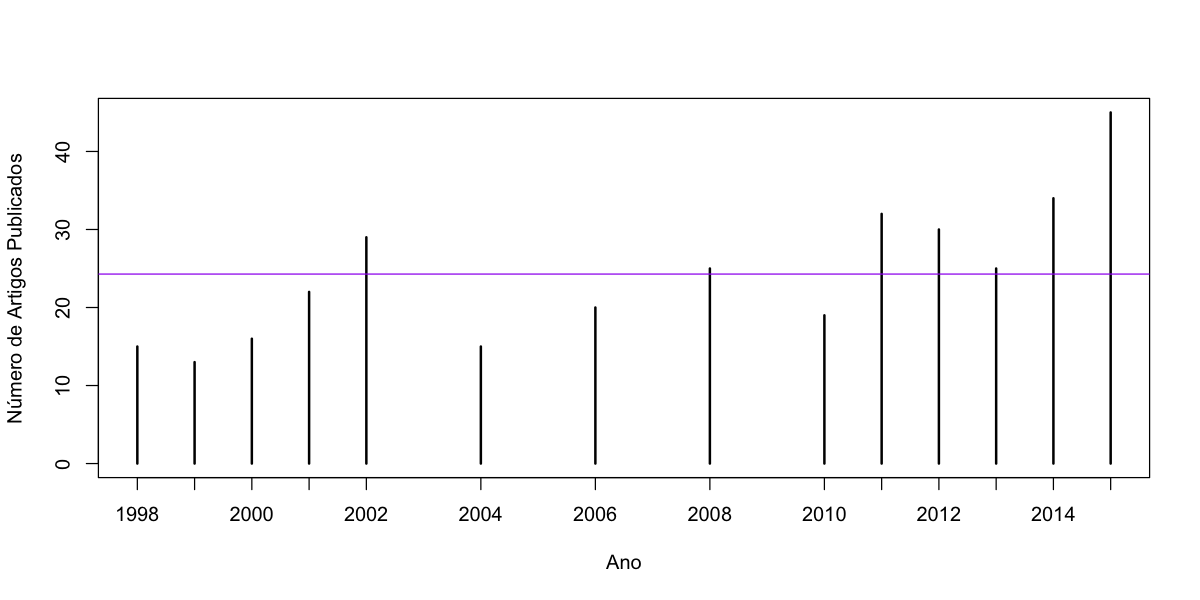

In [51]:
published.per.year = table(data.map[["artigo"]]$ano)
print(published.per.year)
avg.published = mean(published.per.year)
printf("Média de publicações: %.2f", avg.published)
plot(published.per.year, xlab = "Ano", ylab = "Número de Artigos Publicados")
abline(h = avg.published, col = "purple")

### 2   Quantos autores publicaram em cada edição do evento?



|Ano  | Quantidade de Autores|
|:----|---------------------:|
|1998 |                    38|
|1999 |                    27|
|2000 |                    33|
|2001 |                    54|
|2002 |                    67|
|2004 |                    42|
|2006 |                    54|
|2008 |                    64|
|2010 |                    40|
|2011 |                    89|
|2012 |                    68|
|2013 |                    70|
|2014 |                   103|
|2015 |                   122|

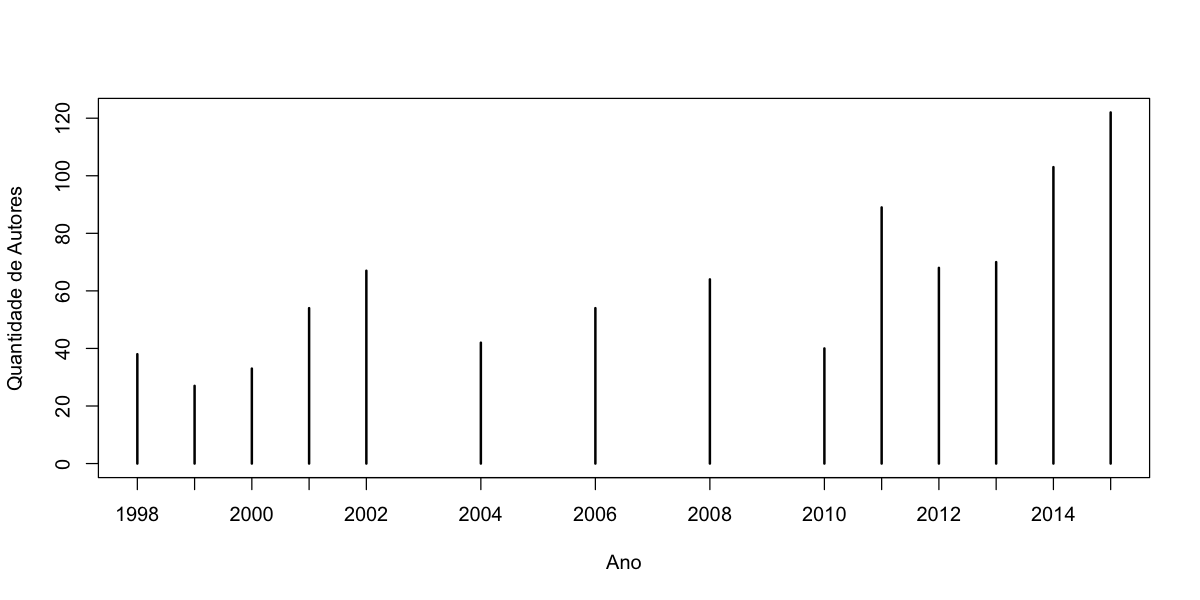

In [52]:
# Obtém os `datasets` de `artigo` e `autor`
artigo = data.map[["artigo"]]
autor = data.map[["autor"]]

# Faz o cruzamento de autores e artigos e remove duplicatas (i.e. autor que publicou mais de uma vez em um mesmo ano)
autor.by.artigo = merge(autor, artigo, by = "id_artigo")
autor.by.artigo = unique(data.frame(id_autor = autor.by.artigo$id_autor, ano = autor.by.artigo$ano))

# Exibe os resultados
qtd.autor.por.evento = table(autor.by.artigo$ano)
qtd.autor.por.evento.df = as.data.frame(qtd.autor.por.evento)
names(qtd.autor.por.evento.df) = c("Ano", "Quantidade de Autores")
kable(qtd.autor.por.evento.df)
plot(qtd.autor.por.evento, ylab="Quantidade de Autores", xlab="Ano")

#### 2.1 Qual a relação entre artigos e autores por evento?

Dado que temos as informações de quantos autores publicaram e quantos artigos foram publicados por evento, pode-se calcular a relação entre estas duas distribuições. Observa-se abaixo que esta relação permaneceu praticamente constante ao longo dos anos na faixa de 2.5, com pequena variação em torno dela. Isto é bastante interessante, por indicar que parte significativa dos artigos tem pelo menos dois autores, tendendo pra três em boa parte dos anos.



|Ano  | Autor vs Artigos|
|:----|----------------:|
|1998 |         2.533333|
|1999 |         2.076923|
|2000 |         2.062500|
|2001 |         2.454546|
|2002 |         2.310345|
|2004 |         2.800000|
|2006 |         2.700000|
|2008 |         2.560000|
|2010 |         2.105263|
|2011 |         2.781250|
|2012 |         2.266667|
|2013 |         2.800000|
|2014 |         3.029412|
|2015 |         2.711111|

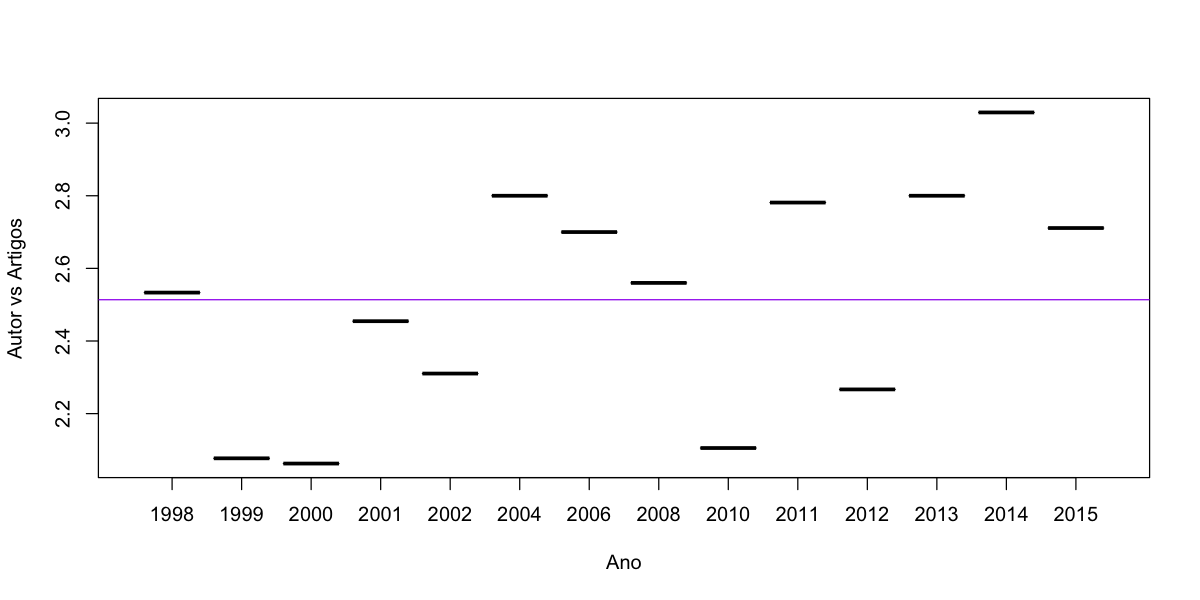

In [53]:
rel.autor.publicacoes = as.data.frame(qtd.autor.por.evento/published.per.year)
names(rel.autor.publicacoes) = c("Ano", "Autor vs Artigos")
kable(as.data.frame(rel.autor.publicacoes))
plot(rel.autor.publicacoes)
abline(h = mean(rel.autor.publicacoes$"Autor vs Artigos"), col='purple')

### 3 Como o número de autores por artigo estão distribuídos a cada edição?

Aqui analisam-se mais a fundo as observações do item [2.1](#2.1-Qual-a-relação-entre-artigos-e-autores-por-evento?). Primeiramente, geram-se as distribuições das contagens, por edição, de autores por cada artigo e exibem-se seus _boxplots_ para que se possa enxerger seu formato. 

Como pode-se observar abaixo, a mediana fica na faixa de $2$ a $3$, como observado no item mencionado. É interessante notar também que nos últimos anos as distribuições aparentam estar mais _right-skewed_, indicando uma elevada frequência relativa de artigos com um alto número de co-autores. Isto pode ser um sintoma do fenômeno de [_Publish or Perish_](https://en.wikipedia.org/wiki/Publish_or_perish), que devido as estruturas do sistema de _funding_ para pesquisas baseado em parte na publicação frequente de artigos, acarreta artigos com um número desproporcional de autores.

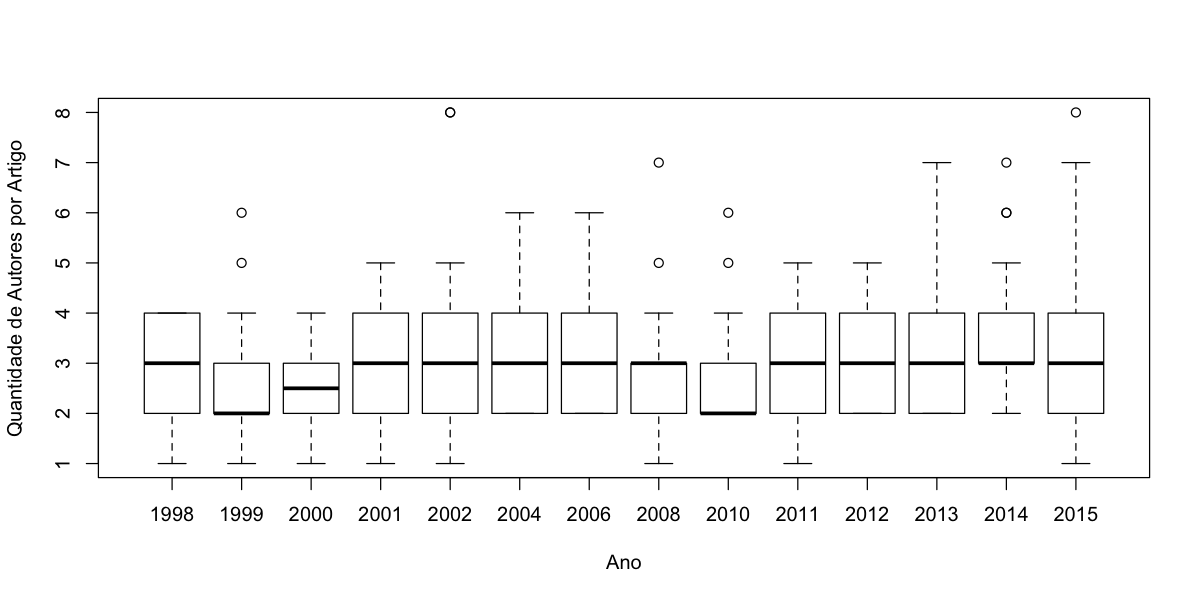

In [54]:
# Obtém os `datasets` de `artigo` e `autor`
artigo = data.map[["artigo"]]
autor = data.map[["autor"]]

# Faz o cruzamento de autores e artigos
autor.by.artigo = merge(autor, artigo, by = "id_artigo")

# Pega a soma de autores por artigo
artigo.sum.per.year = count(autor.by.artigo, c("id_artigo", "ano"))

# Separa e exibe as distribuições por ano
boxplot(artigo.sum.per.year$freq ~ artigo.sum.per.year$ano, xlab="Ano", ylab="Quantidade de Autores por Artigo")

#### 3.1 Qual o artigo que tem tantos autores?

Por curiosidade, peguemos o artigo que teve o maior número de autores publicado em 2015.

In [55]:
# Pega a relação de quantidade de autores por artigo de 2015
artigo.sum.in.2015 = artigo.sum.per.year[artigo.sum.per.year$ano == 2015,]

# Obtém a ID do outlier em número de autores
artigo.id = artigo.sum.in.2015$id_artigo[which.max(artigo.sum.in.2015$freq)]
autor.by.artigo[autor.by.artigo$id_artigo == artigo.id, c("nome", "titulo", "idioma", "ano")]

,nome,titulo,idioma,ano
973,Olavo Giraldi Jr.,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
974,Carlúcio Santos Cordeiro,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
975,Adriana Euflasino,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
976,Edgar Vilela Gadbem,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
977,Leonardo Rodrigo Domingues,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
978,Marcos Henrique Cascone,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
979,Eduardo H. Tanaka,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015
980,Juliana Aramizu Paludo,Design de Interface de um Ambiente de Realidade Virtual Imersiva para o Treinamento de Eletricistas,PT,2015


### 4 Como a proporção entre referências em português e em inglês tem variado ao longo dos anos?

Esta questão será analisada sob duas óticas: primeiramente, será exibida a evolução das proporções com base apenas no banco de dados de referências conhecido, para analisar se no geral, desde a primeira referência observada houve mudanças; posteriormente será analisada a proporção das referências por evento IHC, para ver como se deu essa distribuição por evento.

#### 4.1 Evolução da Proporção no Banco de Referências

Pelo gráfico exibido abaixo, observa-se uma clara tendência ascendente, o que é sempre bom de se ver, com os valores pós-2000 na faixa de $0.2$ a $0.3$, o que é bastante significativo.

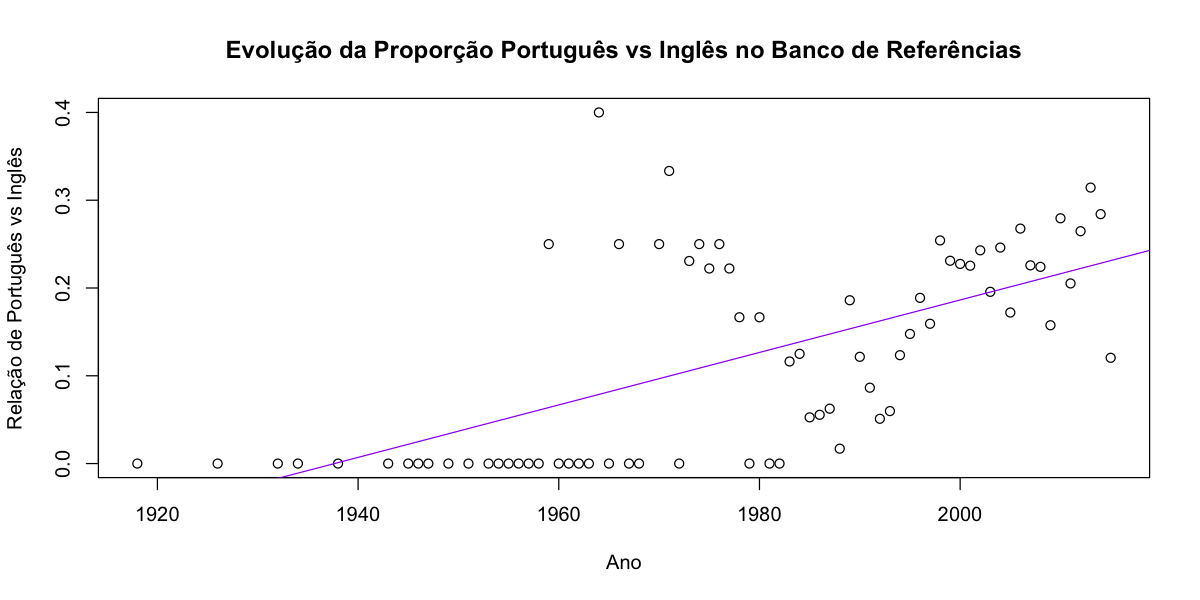

In [122]:
# Obtém o `datasets` de `referência`
referencia = data.map[["referencia"]]

# Faz a contagem de idiomas por ano, limitando-se apenas a anos que tem `EN` (considerado o _superset_)
ref.lang.count.per.year = count(referencia, c("anoref", "idiomaref"))
years.with.english = na.exclude(ref.lang.count.per.year[ref.lang.count.per.year$idiomaref == "EN","anoref"])
ref.lang.count.english.years = 
    (na.exclude(ref.lang.count.per.year[ref.lang.count.per.year$anoref %in% years.with.english, ]))

# Obtém os anos nos quais há referências em Português
years.with.portuguese = na.exclude(ref.lang.count.english.years[ref.lang.count.english.years$idiomaref == "PT","anoref"])

# Calcula as proporções
proportions = rep(0.0, length(years.with.english))
for (year in years.with.portuguese) {
    pt.count = ref.lang.count.english.years$freq[ref.lang.count.english.years$idiomaref == "PT" &
                                                 ref.lang.count.english.years$anoref == year]
    en.count = ref.lang.count.english.years$freq[ref.lang.count.english.years$idiomaref == "EN" &
                                                 ref.lang.count.english.years$anoref == year]
    pt.en.prop = pt.count/as.double(pt.count + en.count)
    proportions[which(years.with.english == year)] = pt.en.prop
}

plot(y = proportions, x = years.with.english, ylab="Relação de Português vs Inglês", xlab="Ano", main="Evolução da Proporção Português vs Inglês no Banco de Referências")
abline(lm(proportions ~ years.with.english), col = "purple")

#### 4.2 Evolução da Proporção Português vs Inglês por Evento

Agora, tracemos gráfico equivalente mas com base nos eventos sobre os quais temos informação, isto é, dados os artigos publicados por ano e suas respectivas referências, qual a proporção de Português e Inglês para estas ao longo dos anos?

,nome.x,nome.y
1,Flavia Rossler,Maria Cecília C. Baranauskas
3,Flavia Rossler,Osvaldo Luiz de Oliveira
4,Osvaldo Luiz de Oliveira,Maria Cecília C. Baranauskas
5,Osvaldo Luiz de Oliveira,Flavia Rossler
8,Maria Cecília C. Baranauskas,Flavia Rossler
9,Maria Cecília C. Baranauskas,Osvaldo Luiz de Oliveira


### 5 Quais autores mais colaboram (publicam artigos em coautoria)?

#### 5.1 Ranking por Colaboração
Primeiramente, é feito um cruzamento entre os autores que colaboraram entre si e então selecionam-se os 10 autores que mais tem colaborações.

In [208]:
# Obtém os `datasets` de `artigo` e `autor`
artigo = data.map[["artigo"]]
autor = data.map[["autor"]]

# Faz o cruzamento de autores e artigos e remove duplicatas (i.e. autor que publicou mais de uma vez em um mesmo ano)
autor.by.artigo = merge(autor, artigo, by = "id_artigo")

# Faz um segundo cruzamento para gerar os pares de autores
coautores = merge(autor, autor.by.artigo, by = "id_artigo")
coautores = coautores[coautores$id_autor.x != coautores$id_autor.y,]

# Conta os autores que mais colaboraram
coautores.count = count(coautores, c("id_autor.x", "nome.x"))
coautores.count = coautores.count[with(coautores.count, order(-freq)), ]
coautores.display = data.frame(Rank = 1:10, Nome = coautores.count$nome.x[1:10], Frequência=coautores.count$freq[1:10])
kable(coautores.display)



| Rank|Nome                          | Frequência|
|----:|:-----------------------------|----------:|
|    1|Clarisse Sieckenius de Souza  |         71|
|    2|Maria Cecília C. Baranauskas  |         57|
|    3|Marcelo Soares Pimenta        |         51|
|    4|Raquel Oliveira Prates        |         48|
|    5|Simone Bacellar Leal Ferreira |         38|
|    6|Simone D. J. Barbosa          |         30|
|    7|Denis S. da Silveira          |         23|
|    8|Heloísa Vieira da Rocha       |         22|
|    9|Carla M. Dal Sasso Freitas    |         21|
|   10|Junia Anacleto                |         18|

Vejamos também quais autores são os que menos colaboram:

In [207]:
num.elem = nrow(coautores.count)
rank.range = seq(num.elem, num.elem-10, -1)
coautores.display = data.frame(
    Rank = rank.range,
    Nome = coautores.count$nome.x[range], 
    Frequência=coautores.count$freq[range])
kable(coautores.display)



| Rank|Nome                               | Frequência|
|----:|:----------------------------------|----------:|
|  652|Wellington B. do Nascimento Jr.    |          1|
|  651|Wander Antunes Gaspar Valente      |          1|
|  650|Vinícius Carvalho Pereira          |          1|
|  649|Vânia Paula de Almeida Neris       |          1|
|  648|Vagner Figuerêdo de Santana        |          1|
|  647|Ugo Braga Sangiorgi                |          1|
|  646|Ticianne Darin                     |          1|
|  645|Tiago Silva da Silva               |          1|
|  644|Thiago Prado de Campos             |          1|
|  643|Tathiane Mendonça Andrade          |          1|
|  642|Taissa Abdalla Filgueiras de Sousa |          1|

#### 5.2 Pares mais Frequentes

Uma pergunta também bem interessante de responder é: quais são os pares de autores que mais frequentemente colaboram entre si? 

In [220]:
# Obtém os pares de coautores e 
coautores.pairs = coautores[,c("nome.x", "nome.y")]
coautores.pairs = coautores.pairs[coautores.pairs$nome.x != coautores.pairs$nome.y,]

# Haverá na base pares repetidos, mas com ordem invertida. Logo, encontram-se tais
#   instâncias e elas são removidas.

# Calcula o número de ocorrência dos pares. Ao final, todos os pares terão sido contados 2
#   vezes, já que os temos no banco de dados original duas vezes, com seu nome em ordens distintas.
#   Logo, divide-se a contagem por 2 ao final.
author.pairs = list()
for (i in 1:nrow(coautores.pairs)) {
    author.pair = coautores.pairs[i, ]
    
    # Get the author names and order them to form the pair
    author.names = c(author.pair$nome.x, author.pair$nome.y)
    author.names = author.names[order(author.names)]
    author.pair.txt = paste(author.names[1], author.names[2], sep=" :: ")
    
    # Add pair to the dictionary if new or update its count if existing
    if (!(author.pair.txt %in% names(author.pairs)))
        author.pairs[[author.pair.txt]] = 1
    else
        author.pairs[[author.pair.txt]] = author.pairs[[author.pair.txt]] + 1
}
        
# Coloca os pares em um formato agradável
author.pairs.values = data.frame(t(as.data.frame(author.pairs)))
author.pairs = data.frame(Pares=names(author.pairs), Freq=author.pairs.values[,1]/2)
        
# Calcula o número de ocorrências dos pares
coautores.pairs = as.data.frame(table(as.character(interaction(coautores.pairs, sep=" :: "))))

# Ordena os pares por ordem decrescente de frequência
coautores.pairs = coautores.pairs[with(coautores.pairs, order(-Freq)), ]

# Exibe os resultados
names(coautores.pairs) = c("Par de Autores", "Frequência")
coautores.display = data.frame(
    Rank = 1:10, 
    Nome = coautores.pairs[1:10, "Par de Autores"],
    Frequência=coautores.pairs[1:10, "Frequência"])
kable(coautores.display)



| Rank|Nome                                                    | Frequência|
|----:|:-------------------------------------------------------|----------:|
|    1|Clarisse Sieckenius de Souza :: Raquel Oliveira Prates  |         10|
|    2|Milene Selbach Silveira :: Simone D. J. Barbosa         |         10|
|    3|Raquel Oliveira Prates :: Clarisse Sieckenius de Souza  |         10|
|    4|Simone D. J. Barbosa :: Milene Selbach Silveira         |         10|
|    5|Clarisse Sieckenius de Souza :: Simone D. J. Barbosa    |          8|
|    6|Paulo R. G. Luzzardi :: Ricardo A. Cava                 |          8|
|    7|Ricardo A. Cava :: Paulo R. G. Luzzardi                 |          8|
|    8|Simone D. J. Barbosa :: Clarisse Sieckenius de Souza    |          8|
|    9|Aline da Silva Alves :: Simone Bacellar Leal Ferreira   |          7|
|   10|Clarisse Sieckenius de Souza :: Milene Selbach Silveira |          7|

Na mesma linha da análise anterior, quais são os pares menos frequentes?

In [222]:
num.elem = nrow(coautores.pairs)
rank.range = seq(num.elem, num.elem-10, -1)
coautores.display = data.frame(
    Rank = rank.range, 
    Nome = coautores.pairs[rank.range, "Par de Autores"],
    Frequência=coautores.pairs[rank.range, "Frequência"])
kable(coautores.display)



| Rank|Nome                                                     | Frequência|
|----:|:--------------------------------------------------------|----------:|
| 2110|Yulia Ostróvskaya :: Norma P. Hernández                  |          1|
| 2109|Yulia Ostróvskaya :: Julio C. Penagos                    |          1|
| 2108|Yulia Ostróvskaya :: J. Alfredo Sánchez                  |          1|
| 2107|Yngve Sundblad :: Helena Tobiasson                       |          1|
| 2106|Yngve Sundblad :: Anders Hedman                          |          1|
| 2105|Williamson Silva :: Tayana Conte                         |          1|
| 2104|Williamson Silva :: Natasha M. C. Valentim               |          1|
| 2103|William J. Giraldo :: Toni Granollers                    |          1|
| 2102|William J. Giraldo :: Maria L. Villegas                  |          1|
| 2101|William J. Giraldo :: Helmuth Trefftz                    |          1|
| 2100|Wellington B. do Nascimento Jr. :: Walter de Abreu Cybi

### 6 Quais autores mais citam outros autores?

### 7 Quais autores têm maior proporção autocitação/citação?

### 8 Como são distribuídos os números de referências citados por cada artigo? Variam muito de edição para edição?

### 9 Quais conferências são mais citadas pelos artigos publicados no IHC (tipo de referência = C)? E quais periódicos (tipo de referência = J)?